## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

## Global Variables

In [2]:
interval = '1d' # time interval for data point
history = '10y' # time period for total history
perc_inc = 0.008 # 0.8% increase from interval to interval
symbol = 'IYW'
perc_train = 0.12 # n_estimators of train data set

## Yahoo Finance

In [3]:
stock_df = yf.download(tickers = symbol
                       , interval = interval
                       , period = history
                       , prepost = True
                      )

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-21,57.660000,57.730000,56.160000,56.450001,51.221802,180700
2010-06-22,56.639999,57.090000,55.849998,55.889999,50.713669,177400
2010-06-23,56.020000,56.200001,55.259998,55.680000,50.523113,154700


In [5]:
stock_df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-17,265.429993,266.200012,263.390015,264.000000,264.000000,92800
2020-06-18,263.690002,265.320007,263.000000,265.190002,265.190002,56300
2020-06-19,268.450012,268.450012,262.630005,264.230011,264.230011,116900


## Create Percent Change

In [6]:
stock_df['Percent Change'] = (stock_df.Open - stock_df.Close) / stock_df.Open
stock_df.head(3)

,Open,High,Low,Close,Adj Close,Volume,Percent Change
Date,,,,,,,
2010-06-21,57.660000,57.730000,56.160000,56.450001,51.221802,180700,0.020985
2010-06-22,56.639999,57.090000,55.849998,55.889999,50.713669,177400,0.013242
2010-06-23,56.020000,56.200001,55.259998,55.680000,50.523113,154700,0.006069


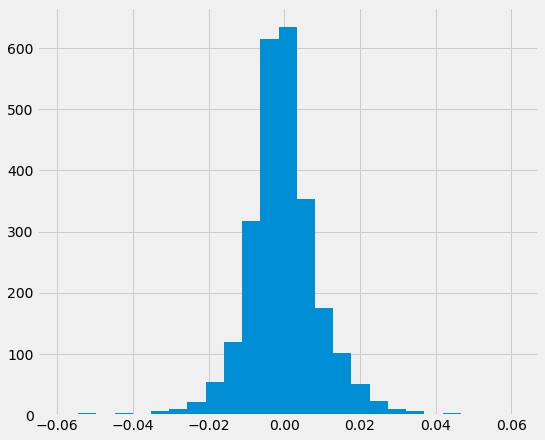

In [7]:
stock_df['Percent Change'].hist(bins=25);

In [8]:
stock_df['Percent Change'].quantile([0.84]) # 1 stdev from avg

0.84    0.007545
Name: Percent Change, dtype: float64